In [5]:
# Run this only if you haven't installed the libraries yet
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap category_encoders


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

import joblib

In [7]:
df = pd.read_csv(r"C:\Users\ACER\Downloads\titanic.csv")  # ✅ Use raw string for Windows path

In [8]:
print("Shape:", df.shape)
display(df.head())
display(df.isnull().sum())

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.')
df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
df['Deck'] = df['Cabin'].fillna('Missing').str[0]
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

In [10]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Title','Deck','FamilySize','IsAlone']
X = df[features]
y = df['Survived']


In [11]:
numeric_features = ['Age','SibSp','Parch','Fare','FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = ['Pclass','Sex','Embarked','Title','Deck','IsAlone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [13]:
rf = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

xgb = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42))
])

Starting training and evaluation...

Training RandomForest...
RandomForest training complete.

--- RandomForest ---
Accuracy: 0.8100558659217877
Precision: 0.7692307692307693
Recall: 0.7246376811594203
F1 Score: 0.746268656716418
ROC-AUC: 0.8284584980237153
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



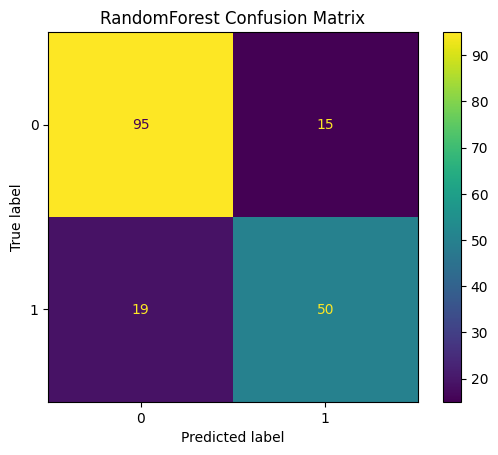


Training XGBoost...


C:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:31:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training complete.

--- XGBoost ---
Accuracy: 0.8268156424581006
Precision: 0.7714285714285715
Recall: 0.782608695652174
F1 Score: 0.7769784172661871
ROC-AUC: 0.8460474308300395
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       110
           1       0.77      0.78      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



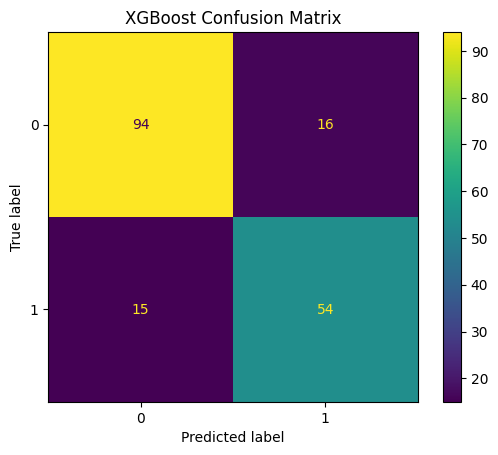

In [14]:
print("Starting training and evaluation...")

for name, model in [('RandomForest', rf), ('XGBoost', xgb)]:
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    print(f"{name} training complete.")
    
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    
    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("Recall:", recall_score(y_test, preds))
    print("F1 Score:", f1_score(y_test, preds))
    print("ROC-AUC:", roc_auc_score(y_test, proba))
    print(classification_report(y_test, preds))
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

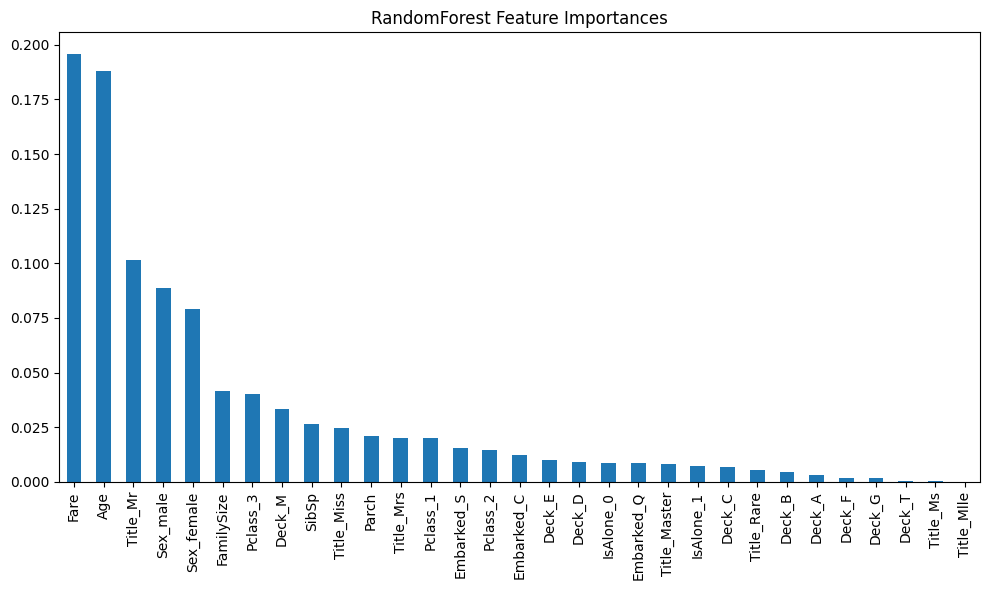

In [15]:
rf.fit(X_train, y_train)
rf_model = rf.named_steps['clf']
rf_features = rf.named_steps['pre'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(rf_features)
importances = rf_model.feature_importances_

feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)
plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar')
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()

In [16]:
joblib.dump(rf, "titanic_rf_pipeline.joblib")

['titanic_rf_pipeline.joblib']

In [18]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


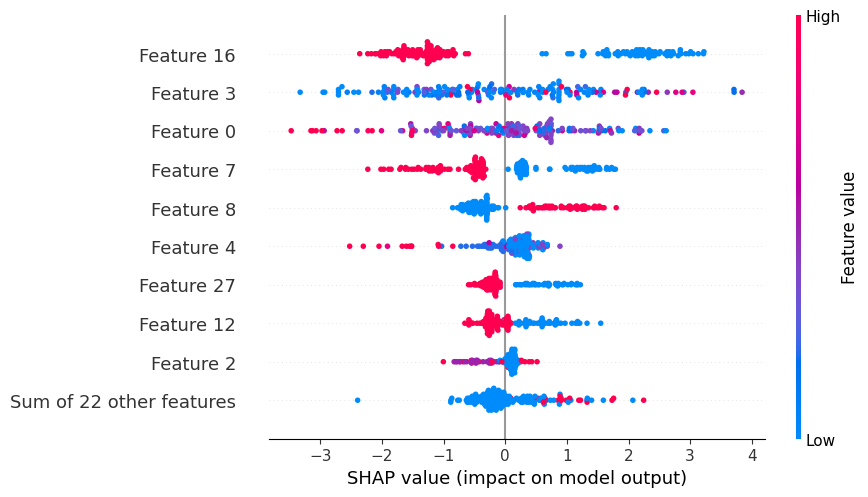

In [19]:
import shap

# Prepare data for SHAP
X_transformed = xgb.named_steps['pre'].transform(X_test)
explainer = shap.Explainer(xgb.named_steps['clf'], X_transformed)
shap_values = explainer(X_transformed)

# Summary plot
shap.plots.beeswarm(shap_values)


In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import joblib

# Load trained model
model = joblib.load("titanic_rf_pipeline.joblib")

def predict_survival():
    try:
        data = {
            'Pclass': [int(pclass_var.get())],
            'Sex': [sex_var.get()],
            'Age': [float(age_var.get())],
            'SibSp': [int(sibsp_var.get())],
            'Parch': [int(parch_var.get())],
            'Fare': [float(fare_var.get())],
            'Embarked': [embarked_var.get()],
            'Title': [title_var.get()],
            'Deck': [deck_var.get()],
            'FamilySize': [int(sibsp_var.get()) + int(parch_var.get()) + 1],
            'IsAlone': [1 if (int(sibsp_var.get()) + int(parch_var.get()) + 1) == 1 else 0]
        }
        df_input = pd.DataFrame(data)
        prediction = model.predict(df_input)[0]
        result = "Survived" if prediction == 1 else "Did Not Survive"
        messagebox.showinfo("Prediction Result", f"The passenger would have: {result}")
    except Exception as e:
        messagebox.showerror("Error", str(e))

# GUI layout
root = tk.Tk()
root.title("Titanic Survival Predictor")

fields = [
    ("Pclass", "1/2/3"), ("Sex", "male/female"), ("Age", "e.g. 29"),
    ("SibSp", "siblings/spouses aboard"), ("Parch", "parents/children aboard"),
    ("Fare", "ticket fare"), ("Embarked", "C/Q/S"), ("Title", "Mr/Mrs/Miss/etc."),
    ("Deck", "A/B/C/D/E/F/G/Missing")
]

vars = []
for i, (label, hint) in enumerate(fields):
    tk.Label(root, text=f"{label} ({hint})").grid(row=i, column=0)
    var = tk.StringVar()
    tk.Entry(root, textvariable=var).grid(row=i, column=1)
    vars.append(var)

pclass_var, sex_var, age_var, sibsp_var, parch_var, fare_var, embarked_var, title_var, deck_var = vars

tk.Button(root, text="Predict Survival", command=predict_survival).grid(row=len(fields), columnspan=2)
root.mainloop()